In [ ]:
!pip install --upgrade progressbar2

  Attempting uninstall: progressbar2
    Found existing installation: progressbar2 3.38.0
    Uninstalling progressbar2-3.38.0:
      Successfully uninstalled progressbar2-3.38.0


In [ ]:
from torch import nn
from collections import OrderedDict
import torch.nn.functional as F
import torch
from torch.utils.data import DataLoader
import torchvision
import random
from torch.utils.data import Subset
from matplotlib import pyplot as plt
from torchsummary import summary
from torchvision import transforms
import progressbar as pb
import numpy as np

In [ ]:
from google.colab import files
uploaded= files.upload()

Saving federated_mnist_best_test.pth to federated_mnist_best_test.pth


In [ ]:
state_dict = torch.load('federated_mnist_best_test.pth')

In [ ]:
state_dict["classifier"]

OrderedDict([('classifier.0.weight',
              tensor([[-1.7600e-02,  2.1243e-02, -9.1289e-03,  ..., -6.3843e-03,
                        1.8552e-02,  1.9946e-02],
                      [-2.2441e-02,  2.1101e-02, -8.2193e-04,  ..., -1.4391e-02,
                       -1.6754e-02,  1.8552e-02],
                      [-2.3806e-02,  2.1773e-02,  1.0257e-03,  ..., -2.3305e-03,
                       -1.8795e-02,  2.2600e-02],
                      ...,
                      [ 1.5982e-02, -1.2334e-05,  1.8411e-03,  ...,  1.5341e-02,
                       -1.5633e-02,  2.4265e-02],
                      [-8.1139e-03,  1.7155e-02, -6.7252e-03,  ..., -1.8207e-02,
                        7.8570e-03, -3.8176e-03],
                      [ 9.6889e-04,  3.1487e-03, -1.2137e-02,  ...,  2.0205e-02,
                        1.8008e-02, -1.9592e-02]], device='cuda:0')),
             ('classifier.0.bias',
              tensor([-0.0061, -0.0193, -0.0059,  ...,  0.0140, -0.0062, -0.0031],
            

In [ ]:
SUM = lambda x,y : x+y

def check_equity(property,a,b):
    pa = getattr(a,property)
    pb = getattr(b,property)
    assert  pa==pb, "Different {}: {}!={}".format(property,pa,pb)

    return pa

def module_unwrap(mod:nn.Module,recursive=False):
    children = OrderedDict()
    try:
        for name, module in mod.named_children():
            if (recursive):
                recursive_call = module_unwrap(module,recursive=True)
                if (len(recursive_call)>0):
                    for k,v in recursive_call.items():
                        children[name+"_"+k] = v
                else:
                    children[name] = module
            else:
                children[name] = module
    except AttributeError:
        pass

    return children

class VGGBlock(nn.Module):
    def __init__(self, in_channels, out_channels,batch_norm=False):

        super().__init__()

        conv2_params = {'kernel_size': (3, 3),
                        'stride'     : (1, 1),
                        'padding'   : 1
                        }

        noop = lambda x : x

        self._batch_norm = batch_norm

        self.conv1 = nn.Conv2d(in_channels=in_channels,out_channels=out_channels , **conv2_params)
        #self.bn1 = nn.BatchNorm2d(out_channels) if batch_norm else noop
        self.bn1 = nn.GroupNorm(32, out_channels) if batch_norm else noop

        self.conv2 = nn.Conv2d(in_channels=out_channels,out_channels=out_channels, **conv2_params)
        #self.bn2 = nn.BatchNorm2d(out_channels) if batch_norm else noop
        self.bn2 = nn.GroupNorm(32, out_channels) if batch_norm else noop

        self.max_pooling = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

    @property
    def batch_norm(self):
        return self._batch_norm

    def forward(self,x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)

        x = self.max_pooling(x)

        return x

class Classifier(nn.Module):

    def __init__(self,num_classes=10):
        super().__init__()

        self.classifier = nn.Sequential(
            nn.Linear(2048, 2048),
            nn.ReLU(True),
            nn.Dropout(p=0.5),
            nn.Linear(2048, 512),
            nn.ReLU(True),
            nn.Dropout(p=0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self,x):

        return self.classifier(x)

class VGG16(nn.Module):

  def __init__(self, input_size, batch_norm=False):
    super(VGG16, self).__init__()

    self.in_channels,self.in_width,self.in_height = input_size

    self.block_1 = VGGBlock(self.in_channels,64,batch_norm=batch_norm)
    self.block_2 = VGGBlock(64, 128,batch_norm=batch_norm)
    self.block_3 = VGGBlock(128, 256,batch_norm=batch_norm)
    self.block_4 = VGGBlock(256,512,batch_norm=batch_norm)


  @property
  def input_size(self):
      return self.in_channels,self.in_width,self.in_height

  def forward(self, x):

    x = self.block_1(x)
    x = self.block_2(x)
    x = self.block_3(x)
    x = self.block_4(x)
    # x = self.avgpool(x)
    x = torch.flatten(x,1)

    return x

class CombinedLoss(nn.Module):
    def __init__(self, loss_a, loss_b, loss_combo, _lambda=1.0):
        super().__init__()
        self.loss_a = loss_a
        self.loss_b = loss_b
        self.loss_combo = loss_combo

        self.register_buffer('_lambda',torch.tensor(float(_lambda),dtype=torch.float32))


    def forward(self,y_hat,y):

        return self.loss_a(y_hat[0],y[0]) + self.loss_b(y_hat[1],y[1]) + self._lambda * self.loss_combo(y_hat[2],torch.cat(y,0))


In [ ]:
DO='TRAIN'

random.seed(47)

combo_fn = SUM

lambda_reg = 1

In [ ]:
def test(net,classifier, loader):

      net.to(dev)
      classifier.to(dev)

      net.eval()

      sum_accuracy = 0

      # Process each batch
      for j, (input, labels) in enumerate(loader):

        input = input.to(dev)
        labels = labels.float().to(dev)

        features = net(input)

        pred = torch.squeeze(classifier(features))

        # https://discuss.pytorch.org/t/bcewithlogitsloss-and-model-accuracy-calculation/59293/ 2
        #pred_labels = (pred >= 0.0).long()  # Binarize predictions to 0 and 1
        _,pred_label = torch.max(pred, dim = 1)
        pred_labels = (pred_label == labels).float()

        batch_accuracy = pred_labels.sum().item() / len(labels)

        # Update accuracy
        sum_accuracy += batch_accuracy

      epoch_accuracy = sum_accuracy / len(loader)
      return epoch_accuracy
      #print(f"Accuracy test: {epoch_accuracy:0.5}")

In [ ]:
def train(nets, loaders, optimizer, criterion, epochs=20, dev=None, save_param=False, model_name="federated_svhn"):
    # try:
      nets = [n.to(dev) for n in nets]

      model_a = module_unwrap(nets[0], True)
      model_b = module_unwrap(nets[1], True)
      model_c = module_unwrap(nets[2], True)

      reg_loss = nn.MSELoss()

      criterion.to(dev)
      reg_loss.to(dev)

      # Initialize history
      history_loss = {"train": [], "val": [], "test": []}
      history_accuracy = {"train": [], "val": [], "test": []}
      history_test = []
      # Store the best val accuracy
      best_val_accuracy = 0
      # Store best accuracy to save the model
      best_accuracy = 0

      # Process each epoch
      for epoch in range(epochs):
        # Initialize epoch variables
        sum_loss = {"train": 0, "val": 0, "test": 0}
        sum_accuracy = {"train": [0,0,0], "val": [0,0,0], "test": [0,0,0]}

        progbar = None
        # Process each split
        for split in ["train", "val", "test"]:
          if split == "train":
            for n in nets:
              n.train()
            widgets = [
              ' [', pb.Timer(), '] ',
              pb.Bar(),
              ' [', pb.ETA(), '] ', pb.Variable('ta','[Train Acc: {formatted_value}]')
            ]

            progbar = pb.ProgressBar(max_value=len(loaders[split][0]),widgets=widgets,redirect_stdout=True)

          else:
            for n in nets:
              n.eval()
          # Process each batch
          for j,((input_a, labels_a),(input_b, labels_b)) in enumerate(zip(loaders[split][0],loaders[split][1])):

            input_a = input_a.to(dev)
            input_b = input_b.to(dev)

            labels_a = labels_a.long().to(dev)
            labels_b = labels_b.long().to(dev)

            inputs = torch.cat([input_a,input_b],axis=0)
            labels = torch.cat([labels_a, labels_b])


            # Reset gradients
            optimizer.zero_grad()
            # Compute output
            features_a = nets[0](input_a)
            features_b = nets[1](input_b)
            features_c = nets[2](inputs)

            pred_a = torch.squeeze(nets[3](features_a))
            pred_b = torch.squeeze(nets[3](features_b))
            pred_c = torch.squeeze(nets[3](features_c))

            loss = criterion(pred_a, labels_a) + criterion(pred_b, labels_b) + criterion(pred_c, labels)

            for n in model_a:
              layer_a = model_a[n]
              layer_b = model_b[n]
              layer_c = model_c[n]
              if (isinstance(layer_a,nn.Conv2d)):
                loss += lambda_reg * reg_loss(combo_fn(layer_a.weight,layer_b.weight),layer_c.weight)
                if (layer_a.bias is not None):
                  loss += lambda_reg * reg_loss(combo_fn(layer_a.bias, layer_b.bias), layer_c.bias)

            # Update loss
            sum_loss[split] += loss.item()
            # Check parameter update
            if split == "train":
              # Compute gradients
              loss.backward()
              # Optimize
              optimizer.step()

            # Compute accuracy

            #https://discuss.pytorch.org/t/bcewithlogitsloss-and-model-accuracy-calculation/59293/ 2
            #pred_labels_a = (pred_a >= 0.0).long()  # Binarize predictions to 0 and 1
            #pred_labels_b = (pred_b >= 0.0).long()  # Binarize predictions to 0 and 1
            #pred_labels_c = (pred_c >= 0.0).long()  # Binarize predictions to 0 and 1

            #print(pred_a.shape)

            _,pred_label_a = torch.max(pred_a, dim = 1)
            pred_labels_a = (pred_label_a == labels_a).float()

            _,pred_label_b = torch.max(pred_b, dim = 1)
            pred_labels_b = (pred_label_b == labels_b).float()

            _,pred_label_c = torch.max(pred_c, dim = 1)
            pred_labels_c = (pred_label_c == labels).float()

            batch_accuracy_a = pred_labels_a.sum().item() / len(labels_a)
            batch_accuracy_b = pred_labels_b.sum().item() / len(labels_b)
            batch_accuracy_c = pred_labels_c.sum().item() / len(labels)

            # Update accuracy
            sum_accuracy[split][0] += batch_accuracy_a
            sum_accuracy[split][1] += batch_accuracy_b
            sum_accuracy[split][2] += batch_accuracy_c


            if (split=='train'):
              progbar.update(j, ta=batch_accuracy_c)

        if (progbar is not None):
          progbar.finish()
        # Compute epoch loss/accuracy
        epoch_loss = {split: sum_loss[split] / len(loaders[split][0]) for split in ["train", "val", "test"]}
        epoch_accuracy = {split: [sum_accuracy[split][i] / len(loaders[split][0]) for i in range(len(sum_accuracy[split])) ] for split in ["train", "val", "test"]}


        print(f"Epoch {epoch + 1}:")
        # Update history
        for split in ["train", "val", "test"]:
          history_loss[split].append(epoch_loss[split])
          history_accuracy[split].append(epoch_accuracy[split])
          # Print info
          print(f"\t{split}\tLoss: {epoch_loss[split]:0.5}\tVGG 1:{epoch_accuracy[split][0]:0.5}"
                f"\tVGG 2:{epoch_accuracy[split][1]:0.5}\tVGG *:{epoch_accuracy[split][2]:0.5}")

        if save_param:
          torch.save({'vgg_a':nets[0].state_dict(),'vgg_b':nets[1].state_dict(),'vgg_star':nets[2].state_dict(),'classifier':nets[3].state_dict()},f'{model_name}.pth')

        
        print(f"Accuracy test VGGA: {test(nets[0], nets[3], test_loader_all):0.5}")
        print(f"Accuracy test VGGB: {test(nets[1], nets[3], test_loader_all):0.5}")
        print(f"Accuracy test VGG*: {test(nets[2], nets[3], test_loader_all):0.5}")
 
        summed_state_dict = OrderedDict()
 
        for key in nets[2].state_dict():
          if key.find('conv') >=0:
            #print(key)
            summed_state_dict[key] = combo_fn(nets[0].state_dict()[key],nets[1].state_dict()[key])
          else:
            summed_state_dict[key] = nets[2].state_dict()[key]
 
        nets[2].load_state_dict(summed_state_dict)
        accuracy_star = test(nets[2], nets[3], test_loader_all)
        print(f"Accuracy test VGGSTAR: {accuracy_star:0.5}")
        history_test.append(accuracy_star)


        # Store params at the best validation accuracy
        if save_param and accuracy_star > best_accuracy:
        # torch.save(net.state_dict(), f"{net.__class__.__name__}_best_val.pth")
          torch.save({'vgg_a':nets[0].state_dict()}, f"{model_name}_best_test.pth")
          best_accuracy = accuracy_star
        print(f"Best accuracy test is: {best_accuracy:0.5}")


      # Plot accuracy
      plt.title("Accuracy VGGSTAR over epochs")
      plt.plot(history_test)
      #plt.legend()
      plt.show()

In [ ]:
# Compose transformations
data_transform = transforms.Compose([
  transforms.Resize((32,32)),
  transforms.Grayscale(num_output_channels=1),
  transforms.RandomHorizontalFlip(),
  transforms.ToTensor(),
])

# Compose transformations
test_transform = transforms.Compose([
  transforms.Resize((32,32)),
  transforms.Grayscale(num_output_channels=1),
  transforms.ToTensor(),
])

base_dir = 'http://ufldl.stanford.edu/housenumbers/'
train_set_svhn = torchvision.datasets.SVHN(root=base_dir, split='train', download=True, transform=data_transform, target_transform=None)
test_set_svhn = torchvision.datasets.SVHN(root=base_dir, split='test', download=True, transform=test_transform)

num_train_svhn = len(train_set_svhn)
num_test_svhn = len(test_set_svhn)
print(f"Num. training samples: {num_train_svhn}")
print(f"Num. test samples:     {num_test_svhn}")

# List of indexes on the training set
train_idx_svhn = list(range(num_train_svhn))

# List of indexes of the test set
test_idx_svhn = list(range(num_test_svhn))

# Shuffle the training set
import random

random.shuffle(train_idx_svhn)
for i in range(10):
  print(train_idx_svhn[i])

# Fraction of the original train set that we want to use as validation set
val_frac = 0.1
# Number of samples of the validation set
num_val = int(num_train_svhn * val_frac) 
num_train = num_train_svhn - num_val

# Split training set
val_idx_svhn = train_idx_svhn[num_train:]
train_idx_svhn = train_idx_svhn[:num_train]

print(f"{num_train} samples used as train set")
print(f"{num_val}  samples used as val set")

val_set_a = Subset(train_set_svhn, val_idx_svhn)
train_set_a = Subset(train_set_svhn, train_idx_svhn)
test_set_a = test_set_svhn

  0%|          | 0/182040794 [00:00<?, ?it/s]

  0%|          | 0/64275384 [00:00<?, ?it/s]

Num. training samples: 73257
Num. test samples:     26032
32553
61316
44598
62771
49643
55735
33610
29224
47794
11023
65932 samples used as train set
7325  samples used as val set


In [ ]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

# Compose transformations
data_transform = transforms.Compose([
  transforms.Resize((32,32)),
  transforms.Grayscale(num_output_channels=1),
  transforms.RandomHorizontalFlip(),
  transforms.ToTensor(),
  AddGaussianNoise(0., 0.2),
])

# Compose transformations
test_transform = transforms.Compose([
  transforms.Resize((32,32)),
  transforms.Grayscale(num_output_channels=1),
  transforms.ToTensor(),
  AddGaussianNoise(0., 0.2),
])

base_dir = 'http://ufldl.stanford.edu/housenumbers/'
train_set_svhn = torchvision.datasets.SVHN(root=base_dir, split='train', download=True, transform=data_transform, target_transform=None)
test_set_svhn = torchvision.datasets.SVHN(root=base_dir, split='test', download=True, transform=test_transform)

num_train_svhn = len(train_set_svhn)
num_test_svhn = len(test_set_svhn)
print(f"Num. training samples: {num_train_svhn}")
print(f"Num. test samples:     {num_test_svhn}")

# List of indexes on the training set
train_idx_svhn = list(range(num_train_svhn))

# List of indexes of the test set
test_idx_svhn = list(range(num_test_svhn))

# Shuffle the training set
import random

random.shuffle(train_idx_svhn)
for i in range(10):
  print(train_idx_svhn[i])

# Fraction of the original train set that we want to use as validation set
val_frac = 0.1
# Number of samples of the validation set
num_val = int(num_train_svhn * val_frac) 
num_train = num_train_svhn - num_val

# Split training set
val_idx_svhn = train_idx_svhn[num_train:]
train_idx_svhn = train_idx_svhn[:num_train]

print(f"{num_train} samples used as train set")
print(f"{num_val}  samples used as val set")

val_set_b = Subset(train_set_svhn, val_idx_svhn)
train_set_b = Subset(train_set_svhn, train_idx_svhn)
test_set_b = test_set_svhn

Using downloaded and verified file: http://ufldl.stanford.edu/housenumbers/train_32x32.mat
Using downloaded and verified file: http://ufldl.stanford.edu/housenumbers/test_32x32.mat
Num. training samples: 73257
Num. test samples:     26032
71735
2294
37394
41658
67878
47765
13987
61249
32585
63761
65932 samples used as train set
7325  samples used as val set


Label: 8


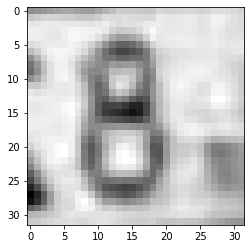

In [ ]:
image, label = train_set_a[7]
plt.imshow(image.squeeze(), cmap='gray')
print('Label:', label)

Label: 3


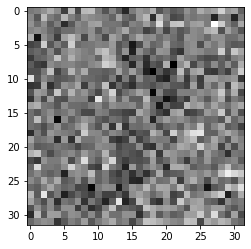

In [ ]:
image, label = train_set_b[5]
plt.imshow(image.squeeze(), cmap='gray')
print('Label:', label)

In [ ]:
test_set = torch.utils.data.ConcatDataset([test_set_a, test_set_b])

# Define loaders

train_loader_a = DataLoader(train_set_a, batch_size=128, num_workers=0, shuffle=True, drop_last=True)
val_loader_a   = DataLoader(val_set_a,   batch_size=128, num_workers=0, shuffle=False, drop_last=False)
test_loader_a  = DataLoader(test_set_a,  batch_size=128, num_workers=0, shuffle=False, drop_last=False)

train_loader_b = DataLoader(train_set_b, batch_size=128, num_workers=0, shuffle=True, drop_last=True)
val_loader_b   = DataLoader(val_set_b,   batch_size=128, num_workers=0, shuffle=False, drop_last=False)
test_loader_b  = DataLoader(test_set_b,  batch_size=128, num_workers=0, shuffle=False, drop_last=False)

test_loader_all = DataLoader(test_set,batch_size=128, num_workers=0,shuffle=False,drop_last=False)


# Define dictionary of loaders
loaders = {"train": [train_loader_a,train_loader_b],
           "val":   [val_loader_a,val_loader_b],
           "test":  [test_loader_a,test_loader_b]}

In [ ]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


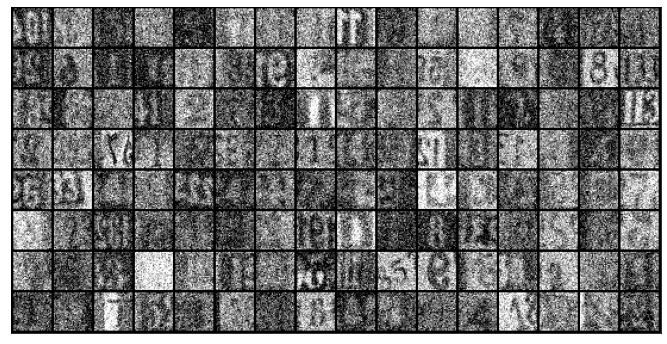

In [ ]:
show_batch(train_loader_b)

In [ ]:
model1 = VGG16((1,32,32),batch_norm=True)
model2 = VGG16((1,32,32),batch_norm=True)
model3 = VGG16((1,32,32),batch_norm=True)
classifier = Classifier(num_classes=10)

In [ ]:
classifier.load_state_dict(state_dict['classifier'])

<All keys matched successfully>

In [ ]:
# We set require_grad = False for all the layer of the net
for param in classifier.parameters():
  param.requires_grad = False

In [ ]:
nets = [model1,model2,model3,classifier]

dev = torch.device('cuda')

parameters = set()

for n in nets:
  parameters |= set(n.parameters())

optimizer = torch.optim.SGD(parameters, lr = 0.01)
# Define a loss
#criterion = nn.BCEWithLogitsLoss()#,nn.BCEWithLogitsLoss(),nn.BCEWithLogitsLoss(),_lambda = 1)
criterion = nn.CrossEntropyLoss()
n_params = 0

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
 [Elapsed Time: 0:01:42] |###############| [Time:  0:01:42] [Train Acc:  0.648]


Epoch 1:
	train	Loss: 5.4844	VGG 1:0.47363	VGG 2:0.19994	VGG *:0.46316
	val	Loss: 3.6544	VGG 1:0.79157	VGG 2:0.30829	VGG *:0.69844
	test	Loss: 3.6552	VGG 1:0.77999	VGG 2:0.32146	VGG *:0.70214
Accuracy test VGGA: 0.62634
Accuracy test VGGB: 0.34765
Accuracy test VGG*: 0.70066
Accuracy test VGGSTAR: 0.19667
Best accuracy test is: 0.19667


 [Elapsed Time: 0:01:42] |###############| [Time:  0:01:42] [Train Acc:  0.707]


Epoch 2:
	train	Loss: 3.2408	VGG 1:0.81746	VGG 2:0.51807	VGG *:0.59985
	val	Loss: 2.5686	VGG 1:0.86107	VGG 2:0.57669	VGG *:0.71374
	test	Loss: 2.5111	VGG 1:0.85825	VGG 2:0.60341	VGG *:0.71791
Accuracy test VGGA: 0.66934
Accuracy test VGGB: 0.66855
Accuracy test VGG*: 0.71828
Accuracy test VGGSTAR: 0.20913
Best accuracy test is: 0.20913


 [Elapsed Time: 0:01:42] |###############| [Time:  0:01:42] [Train Acc:  0.719]


Epoch 3:
	train	Loss: 2.652	VGG 1:0.86558	VGG 2:0.62637	VGG *:0.65012
	val	Loss: 2.2077	VGG 1:0.88976	VGG 2:0.66194	VGG *:0.73671
	test	Loss: 2.2153	VGG 1:0.88274	VGG 2:0.67628	VGG *:0.73772
Accuracy test VGGA: 0.68982
Accuracy test VGGB: 0.736
Accuracy test VGG*: 0.7364
Accuracy test VGGSTAR: 0.19651
Best accuracy test is: 0.20913


 [Elapsed Time: 0:01:42] |###############| [Time:  0:01:42] [Train Acc:  0.695]


Epoch 4:
	train	Loss: 2.4099	VGG 1:0.88864	VGG 2:0.65539	VGG *:0.68247
	val	Loss: 2.1284	VGG 1:0.88672	VGG 2:0.67796	VGG *:0.74678
	test	Loss: 2.1621	VGG 1:0.88253	VGG 2:0.68478	VGG *:0.74308
Accuracy test VGGA: 0.67976
Accuracy test VGGB: 0.74923
Accuracy test VGG*: 0.74494
Accuracy test VGGSTAR: 0.21952
Best accuracy test is: 0.21952


 [Elapsed Time: 0:01:42] |###############| [Time:  0:01:42] [Train Acc:  0.773]


Epoch 5:
	train	Loss: 2.2623	VGG 1:0.9036	VGG 2:0.67065	VGG *:0.70051
	val	Loss: 2.0307	VGG 1:0.90215	VGG 2:0.69061	VGG *:0.75692
	test	Loss: 2.0901	VGG 1:0.89809	VGG 2:0.68259	VGG *:0.74997
Accuracy test VGGA: 0.69723
Accuracy test VGGB: 0.74455
Accuracy test VGG*: 0.74671
Accuracy test VGGSTAR: 0.20834
Best accuracy test is: 0.21952


 [Elapsed Time: 0:01:42] |###############| [Time:  0:01:42] [Train Acc:   0.73]


Epoch 6:
	train	Loss: 2.1591	VGG 1:0.91464	VGG 2:0.6856	VGG *:0.71107
	val	Loss: 2.0318	VGG 1:0.90722	VGG 2:0.68401	VGG *:0.75887
	test	Loss: 2.0639	VGG 1:0.90008	VGG 2:0.6906	VGG *:0.7534
Accuracy test VGGA: 0.68194
Accuracy test VGGB: 0.74843
Accuracy test VGG*: 0.75335
Accuracy test VGGSTAR: 0.19808
Best accuracy test is: 0.21952


 [Elapsed Time: 0:01:42] |###############| [Time:  0:01:42] [Train Acc:   0.77]


Epoch 7:
	train	Loss: 2.077	VGG 1:0.92319	VGG 2:0.69367	VGG *:0.72158
	val	Loss: 1.9416	VGG 1:0.91279	VGG 2:0.69893	VGG *:0.76933
	test	Loss: 1.9643	VGG 1:0.9105	VGG 2:0.69739	VGG *:0.7623
Accuracy test VGGA: 0.69792
Accuracy test VGGB: 0.76356
Accuracy test VGG*: 0.76481
Accuracy test VGGSTAR: 0.21083
Best accuracy test is: 0.21952


 [Elapsed Time: 0:01:41] |###############| [Time:  0:01:41] [Train Acc:   0.75]


Epoch 8:
	train	Loss: 2.0141	VGG 1:0.92952	VGG 2:0.70021	VGG *:0.72803
	val	Loss: 1.8947	VGG 1:0.91697	VGG 2:0.69901	VGG *:0.76796
	test	Loss: 1.9027	VGG 1:0.91881	VGG 2:0.7109	VGG *:0.76974
Accuracy test VGGA: 0.698
Accuracy test VGGB: 0.77776
Accuracy test VGG*: 0.77072
Accuracy test VGGSTAR: 0.22844
Best accuracy test is: 0.22844


 [Elapsed Time: 0:01:41] |###############| [Time:  0:01:41] [Train Acc:  0.754]


Epoch 9:
	train	Loss: 1.9536	VGG 1:0.93582	VGG 2:0.70686	VGG *:0.73529
	val	Loss: 1.9058	VGG 1:0.91374	VGG 2:0.69796	VGG *:0.7736
	test	Loss: 1.9176	VGG 1:0.91188	VGG 2:0.70703	VGG *:0.76908
Accuracy test VGGA: 0.68674
Accuracy test VGGB: 0.76983
Accuracy test VGG*: 0.76949
Accuracy test VGGSTAR: 0.22334
Best accuracy test is: 0.22844


 [Elapsed Time: 0:01:41] |###############| [Time:  0:01:41] [Train Acc:  0.793]


Epoch 10:
	train	Loss: 1.9111	VGG 1:0.94041	VGG 2:0.71177	VGG *:0.74083
	val	Loss: 1.8539	VGG 1:0.91993	VGG 2:0.70693	VGG *:0.77733
	test	Loss: 1.836	VGG 1:0.92251	VGG 2:0.72393	VGG *:0.7736
Accuracy test VGGA: 0.69291
Accuracy test VGGB: 0.78068
Accuracy test VGG*: 0.77198
Accuracy test VGGSTAR: 0.21862
Best accuracy test is: 0.22844


 [Elapsed Time: 0:01:41] |###############| [Time:  0:01:41] [Train Acc:  0.762]


Epoch 11:
	train	Loss: 1.8642	VGG 1:0.94589	VGG 2:0.71745	VGG *:0.74486
	val	Loss: 1.8369	VGG 1:0.91799	VGG 2:0.71782	VGG *:0.78208
	test	Loss: 1.84	VGG 1:0.91414	VGG 2:0.72801	VGG *:0.77669
Accuracy test VGGA: 0.68751
Accuracy test VGGB: 0.79077
Accuracy test VGG*: 0.77685
Accuracy test VGGSTAR: 0.21217
Best accuracy test is: 0.22844


 [Elapsed Time: 0:01:42] |###############| [Time:  0:01:42] [Train Acc:  0.746]


Epoch 12:
	train	Loss: 1.8264	VGG 1:0.95106	VGG 2:0.72037	VGG *:0.74782
	val	Loss: 1.772	VGG 1:0.9278	VGG 2:0.72711	VGG *:0.78517
	test	Loss: 1.7896	VGG 1:0.92693	VGG 2:0.73084	VGG *:0.77666
Accuracy test VGGA: 0.69685
Accuracy test VGGB: 0.79298
Accuracy test VGG*: 0.77541
Accuracy test VGGSTAR: 0.23416
Best accuracy test is: 0.23416


 [Elapsed Time: 0:01:42] |###############| [Time:  0:01:42] [Train Acc:  0.828]


Epoch 13:
	train	Loss: 1.7945	VGG 1:0.9566	VGG 2:0.72383	VGG *:0.75125
	val	Loss: 1.7931	VGG 1:0.92263	VGG 2:0.71914	VGG *:0.78471
	test	Loss: 1.7945	VGG 1:0.91992	VGG 2:0.73052	VGG *:0.78202
Accuracy test VGGA: 0.69289
Accuracy test VGGB: 0.79033
Accuracy test VGG*: 0.77954
Accuracy test VGGSTAR: 0.25369
Best accuracy test is: 0.25369


 [Elapsed Time: 0:01:42] |###############| [Time:  0:01:42] [Train Acc:   0.77]


Epoch 14:
	train	Loss: 1.754	VGG 1:0.95916	VGG 2:0.72831	VGG *:0.75601
	val	Loss: 1.8087	VGG 1:0.92039	VGG 2:0.71784	VGG *:0.77992
	test	Loss: 1.7838	VGG 1:0.9169	VGG 2:0.73529	VGG *:0.78568
Accuracy test VGGA: 0.68322
Accuracy test VGGB: 0.79686
Accuracy test VGG*: 0.784
Accuracy test VGGSTAR: 0.26753
Best accuracy test is: 0.26753


 [Elapsed Time: 0:01:41] |###############| [Time:  0:01:41] [Train Acc:  0.809]


Epoch 15:
	train	Loss: 1.7267	VGG 1:0.96447	VGG 2:0.73064	VGG *:0.7575
	val	Loss: 1.7609	VGG 1:0.92249	VGG 2:0.73139	VGG *:0.78689
	test	Loss: 1.7801	VGG 1:0.92004	VGG 2:0.73501	VGG *:0.78168
Accuracy test VGGA: 0.68982
Accuracy test VGGB: 0.80224
Accuracy test VGG*: 0.7806
Accuracy test VGGSTAR: 0.27174
Best accuracy test is: 0.27174


 [Elapsed Time: 0:01:41] |###############| [Time:  0:01:41] [Train Acc:  0.793]


Epoch 16:
	train	Loss: 1.7083	VGG 1:0.96541	VGG 2:0.73081	VGG *:0.76
	val	Loss: 1.7306	VGG 1:0.92363	VGG 2:0.73353	VGG *:0.7919
	test	Loss: 1.7851	VGG 1:0.91881	VGG 2:0.73249	VGG *:0.78642
Accuracy test VGGA: 0.68765
Accuracy test VGGB: 0.79374
Accuracy test VGG*: 0.78482
Accuracy test VGGSTAR: 0.28531
Best accuracy test is: 0.28531


 [Elapsed Time: 0:01:41] |###############| [Time:  0:01:41] [Train Acc:  0.805]


Epoch 17:
	train	Loss: 1.6632	VGG 1:0.96996	VGG 2:0.73642	VGG *:0.76393
	val	Loss: 1.7345	VGG 1:0.92505	VGG 2:0.73592	VGG *:0.7941
	test	Loss: 1.7112	VGG 1:0.92689	VGG 2:0.74423	VGG *:0.79192
Accuracy test VGGA: 0.7009
Accuracy test VGGB: 0.8067
Accuracy test VGG*: 0.78832
Accuracy test VGGSTAR: 0.27902
Best accuracy test is: 0.28531


 [Elapsed Time: 0:01:41] |###############| [Time:  0:01:41] [Train Acc:  0.789]


Epoch 18:
	train	Loss: 1.6583	VGG 1:0.97192	VGG 2:0.73536	VGG *:0.7639
	val	Loss: 1.7424	VGG 1:0.92492	VGG 2:0.73189	VGG *:0.79867
	test	Loss: 1.7866	VGG 1:0.92084	VGG 2:0.734	VGG *:0.78953
Accuracy test VGGA: 0.68368
Accuracy test VGGB: 0.79945
Accuracy test VGG*: 0.79167
Accuracy test VGGSTAR: 0.32404
Best accuracy test is: 0.32404


 [Elapsed Time: 0:01:41] |###############| [Time:  0:01:41] [Train Acc:  0.812]


Epoch 19:
	train	Loss: 1.6271	VGG 1:0.97567	VGG 2:0.73909	VGG *:0.76692
	val	Loss: 1.7213	VGG 1:0.92928	VGG 2:0.73624	VGG *:0.79724
	test	Loss: 1.7126	VGG 1:0.92765	VGG 2:0.74505	VGG *:0.79407
Accuracy test VGGA: 0.69398
Accuracy test VGGB: 0.80515
Accuracy test VGG*: 0.79529
Accuracy test VGGSTAR: 0.2682
Best accuracy test is: 0.32404


 [Elapsed Time: 0:01:41] |###############| [Time:  0:01:41] [Train Acc:  0.777]


Epoch 20:
	train	Loss: 1.6112	VGG 1:0.97725	VGG 2:0.74123	VGG *:0.76857
	val	Loss: 1.7412	VGG 1:0.92969	VGG 2:0.7328	VGG *:0.7929
	test	Loss: 1.7342	VGG 1:0.92558	VGG 2:0.74789	VGG *:0.78888
Accuracy test VGGA: 0.68437
Accuracy test VGGB: 0.80969
Accuracy test VGG*: 0.7904
Accuracy test VGGSTAR: 0.31437
Best accuracy test is: 0.32404


 [Elapsed Time: 0:01:41] |###############| [Time:  0:01:41] [Train Acc:  0.785]


Epoch 21:
	train	Loss: 1.5838	VGG 1:0.98045	VGG 2:0.7439	VGG *:0.76948
	val	Loss: 1.7266	VGG 1:0.92497	VGG 2:0.73452	VGG *:0.79743
	test	Loss: 1.7256	VGG 1:0.92249	VGG 2:0.74557	VGG *:0.79532
Accuracy test VGGA: 0.68869
Accuracy test VGGB: 0.80775
Accuracy test VGG*: 0.79604
Accuracy test VGGSTAR: 0.32293
Best accuracy test is: 0.32404


 [Elapsed Time: 0:01:41] |###############| [Time:  0:01:41] [Train Acc:  0.781]


Epoch 22:
	train	Loss: 1.5681	VGG 1:0.98307	VGG 2:0.74337	VGG *:0.77275
	val	Loss: 1.7223	VGG 1:0.92578	VGG 2:0.73538	VGG *:0.79992
	test	Loss: 1.7153	VGG 1:0.92613	VGG 2:0.74771	VGG *:0.79669
Accuracy test VGGA: 0.68629
Accuracy test VGGB: 0.80503
Accuracy test VGG*: 0.79735
Accuracy test VGGSTAR: 0.31832
Best accuracy test is: 0.32404


 [Elapsed Time: 0:01:42] |###############| [Time:  0:01:42] [Train Acc:  0.805]


Epoch 23:
	train	Loss: 1.5577	VGG 1:0.98398	VGG 2:0.74677	VGG *:0.77277
	val	Loss: 1.6851	VGG 1:0.92901	VGG 2:0.74441	VGG *:0.80321
	test	Loss: 1.6833	VGG 1:0.92578	VGG 2:0.75149	VGG *:0.80087
Accuracy test VGGA: 0.68859
Accuracy test VGGB: 0.81265
Accuracy test VGG*: 0.79943
Accuracy test VGGSTAR: 0.31375
Best accuracy test is: 0.32404


 [Elapsed Time: 0:01:41] |###############| [Time:  0:01:41] [Train Acc:   0.73]


Epoch 24:
	train	Loss: 1.5373	VGG 1:0.98686	VGG 2:0.74841	VGG *:0.77493
	val	Loss: 1.7193	VGG 1:0.92955	VGG 2:0.74411	VGG *:0.79723
	test	Loss: 1.7179	VGG 1:0.92702	VGG 2:0.7535	VGG *:0.79217
Accuracy test VGGA: 0.68669
Accuracy test VGGB: 0.80888
Accuracy test VGG*: 0.79446
Accuracy test VGGSTAR: 0.32317
Best accuracy test is: 0.32404


 [Elapsed Time: 0:01:41] |###############| [Time:  0:01:41] [Train Acc:   0.82]


Epoch 25:
	train	Loss: 1.515	VGG 1:0.98926	VGG 2:0.75024	VGG *:0.77678
	val	Loss: 1.7055	VGG 1:0.93184	VGG 2:0.74032	VGG *:0.80169
	test	Loss: 1.689	VGG 1:0.92915	VGG 2:0.75359	VGG *:0.79998
Accuracy test VGGA: 0.69089
Accuracy test VGGB: 0.81389
Accuracy test VGG*: 0.79869
Accuracy test VGGSTAR: 0.35994
Best accuracy test is: 0.35994


 [Elapsed Time: 0:01:41] |###############| [Time:  0:01:41] [Train Acc:  0.793]


Epoch 26:
	train	Loss: 1.5074	VGG 1:0.99015	VGG 2:0.75285	VGG *:0.77757
	val	Loss: 1.7202	VGG 1:0.92815	VGG 2:0.74005	VGG *:0.80361
	test	Loss: 1.7115	VGG 1:0.92412	VGG 2:0.75101	VGG *:0.80107
Accuracy test VGGA: 0.67263
Accuracy test VGGB: 0.81361
Accuracy test VGG*: 0.80157
Accuracy test VGGSTAR: 0.37594
Best accuracy test is: 0.37594


 [Elapsed Time: 0:01:41] |###############| [Time:  0:01:41] [Train Acc:  0.797]


Epoch 27:
	train	Loss: 1.4932	VGG 1:0.99228	VGG 2:0.75199	VGG *:0.77903
	val	Loss: 1.7046	VGG 1:0.92484	VGG 2:0.74284	VGG *:0.8055
	test	Loss: 1.7023	VGG 1:0.922	VGG 2:0.75776	VGG *:0.80325
Accuracy test VGGA: 0.67777
Accuracy test VGGB: 0.8173
Accuracy test VGG*: 0.80276
Accuracy test VGGSTAR: 0.37505
Best accuracy test is: 0.37594


 [Elapsed Time: 0:01:41] |###############| [Time:  0:01:41] [Train Acc:  0.777]


Epoch 28:
	train	Loss: 1.4769	VGG 1:0.99269	VGG 2:0.75308	VGG *:0.78129
	val	Loss: 1.6921	VGG 1:0.92888	VGG 2:0.74661	VGG *:0.8071
	test	Loss: 1.7129	VGG 1:0.925	VGG 2:0.74843	VGG *:0.79704
Accuracy test VGGA: 0.67846
Accuracy test VGGB: 0.81125
Accuracy test VGG*: 0.79823
Accuracy test VGGSTAR: 0.40106
Best accuracy test is: 0.40106


 [Elapsed Time: 0:01:41] |###############| [Time:  0:01:41] [Train Acc:  0.797]


Epoch 29:
	train	Loss: 1.473	VGG 1:0.99296	VGG 2:0.75469	VGG *:0.78223
	val	Loss: 1.704	VGG 1:0.92977	VGG 2:0.74098	VGG *:0.80497
	test	Loss: 1.7075	VGG 1:0.92712	VGG 2:0.74981	VGG *:0.80215
Accuracy test VGGA: 0.68216
Accuracy test VGGB: 0.81071
Accuracy test VGG*: 0.8029
Accuracy test VGGSTAR: 0.3986
Best accuracy test is: 0.40106


 [Elapsed Time: 0:01:41] |###############| [Time:  0:01:41] [Train Acc:   0.82]


Epoch 30:
	train	Loss: 1.4618	VGG 1:0.99401	VGG 2:0.75657	VGG *:0.78207
	val	Loss: 1.6977	VGG 1:0.92767	VGG 2:0.74478	VGG *:0.80517
	test	Loss: 1.6518	VGG 1:0.92593	VGG 2:0.76448	VGG *:0.80866
Accuracy test VGGA: 0.68392
Accuracy test VGGB: 0.82029
Accuracy test VGG*: 0.80596
Accuracy test VGGSTAR: 0.38372
Best accuracy test is: 0.40106


 [Elapsed Time: 0:01:41] |###############| [Time:  0:01:41] [Train Acc:  0.785]


Epoch 31:
	train	Loss: 1.4481	VGG 1:0.99565	VGG 2:0.75878	VGG *:0.78357
	val	Loss: 1.7268	VGG 1:0.92909	VGG 2:0.74613	VGG *:0.80345
	test	Loss: 1.7009	VGG 1:0.92842	VGG 2:0.75588	VGG *:0.80268
Accuracy test VGGA: 0.68177
Accuracy test VGGB: 0.80958
Accuracy test VGG*: 0.80189
Accuracy test VGGSTAR: 0.38317
Best accuracy test is: 0.40106


 [Elapsed Time: 0:01:41] |###############| [Time:  0:01:41] [Train Acc:  0.785]


Epoch 32:
	train	Loss: 1.443	VGG 1:0.99678	VGG 2:0.75786	VGG *:0.78384
	val	Loss: 1.7014	VGG 1:0.92821	VGG 2:0.74859	VGG *:0.81121
	test	Loss: 1.6736	VGG 1:0.92713	VGG 2:0.76028	VGG *:0.80762
Accuracy test VGGA: 0.685
Accuracy test VGGB: 0.81645
Accuracy test VGG*: 0.80564
Accuracy test VGGSTAR: 0.42285
Best accuracy test is: 0.42285


 [Elapsed Time: 0:01:41] |###############| [Time:  0:01:41] [Train Acc:   0.73]


Epoch 33:
	train	Loss: 1.4274	VGG 1:0.99671	VGG 2:0.76157	VGG *:0.78626
	val	Loss: 1.7283	VGG 1:0.92834	VGG 2:0.74524	VGG *:0.80738
	test	Loss: 1.7216	VGG 1:0.92537	VGG 2:0.75503	VGG *:0.80017
Accuracy test VGGA: 0.68916
Accuracy test VGGB: 0.81432
Accuracy test VGG*: 0.80197
Accuracy test VGGSTAR: 0.44921
Best accuracy test is: 0.44921


 [Elapsed Time: 0:01:41] |###############| [Time:  0:01:41] [Train Acc:  0.836]


Epoch 34:
	train	Loss: 1.414	VGG 1:0.99744	VGG 2:0.76142	VGG *:0.78788
	val	Loss: 1.6728	VGG 1:0.92802	VGG 2:0.75599	VGG *:0.81179
	test	Loss: 1.666	VGG 1:0.92796	VGG 2:0.76515	VGG *:0.80949
Accuracy test VGGA: 0.68758
Accuracy test VGGB: 0.81965
Accuracy test VGG*: 0.80865
Accuracy test VGGSTAR: 0.42284
Best accuracy test is: 0.44921


 [Elapsed Time: 0:01:42] |###############| [Time:  0:01:42] [Train Acc:  0.832]


Epoch 35:
	train	Loss: 1.4125	VGG 1:0.99807	VGG 2:0.76156	VGG *:0.78664
	val	Loss: 1.6953	VGG 1:0.92963	VGG 2:0.75352	VGG *:0.81059
	test	Loss: 1.7024	VGG 1:0.92582	VGG 2:0.7608	VGG *:0.80466
Accuracy test VGGA: 0.68515
Accuracy test VGGB: 0.81933
Accuracy test VGG*: 0.80476
Accuracy test VGGSTAR: 0.39954
Best accuracy test is: 0.44921


 [Elapsed Time: 0:01:41] |###############| [Time:  0:01:41] [Train Acc:  0.801]


Epoch 36:
	train	Loss: 1.4017	VGG 1:0.99879	VGG 2:0.76452	VGG *:0.78971
	val	Loss: 1.6774	VGG 1:0.93157	VGG 2:0.7602	VGG *:0.81545
	test	Loss: 1.6932	VGG 1:0.93077	VGG 2:0.75692	VGG *:0.80885
Accuracy test VGGA: 0.69318
Accuracy test VGGB: 0.81826
Accuracy test VGG*: 0.80609
Accuracy test VGGSTAR: 0.4322
Best accuracy test is: 0.44921


 [Elapsed Time: 0:01:41] |###############| [Time:  0:01:41] [Train Acc:  0.793]


Epoch 37:
	train	Loss: 1.3991	VGG 1:0.9991	VGG 2:0.76197	VGG *:0.7905
	val	Loss: 1.6945	VGG 1:0.93138	VGG 2:0.75694	VGG *:0.8147
	test	Loss: 1.692	VGG 1:0.92927	VGG 2:0.75837	VGG *:0.80888
Accuracy test VGGA: 0.68479
Accuracy test VGGB: 0.81681
Accuracy test VGG*: 0.81002
Accuracy test VGGSTAR: 0.3821
Best accuracy test is: 0.44921


 [Elapsed Time: 0:01:41] |###############| [Time:  0:01:41] [Train Acc:  0.789]


Epoch 38:
	train	Loss: 1.3913	VGG 1:0.99927	VGG 2:0.76672	VGG *:0.78988
	val	Loss: 1.6799	VGG 1:0.93252	VGG 2:0.75645	VGG *:0.81307
	test	Loss: 1.6912	VGG 1:0.93253	VGG 2:0.75648	VGG *:0.80586
Accuracy test VGGA: 0.69421
Accuracy test VGGB: 0.81186
Accuracy test VGG*: 0.80594
Accuracy test VGGSTAR: 0.39674
Best accuracy test is: 0.44921


 [Elapsed Time: 0:01:41] |###############| [Time:  0:01:41] [Train Acc:  0.766]


Epoch 39:
	train	Loss: 1.3905	VGG 1:0.99886	VGG 2:0.76291	VGG *:0.79139
	val	Loss: 1.6827	VGG 1:0.92969	VGG 2:0.75039	VGG *:0.81167
	test	Loss: 1.6775	VGG 1:0.93053	VGG 2:0.76273	VGG *:0.81073
Accuracy test VGGA: 0.69109
Accuracy test VGGB: 0.82032
Accuracy test VGG*: 0.81071
Accuracy test VGGSTAR: 0.41403
Best accuracy test is: 0.44921


 [Elapsed Time: 0:01:41] |###############| [Time:  0:01:41] [Train Acc:  0.773]


Epoch 40:
	train	Loss: 1.3756	VGG 1:0.99938	VGG 2:0.76743	VGG *:0.79262
	val	Loss: 1.7	VGG 1:0.93103	VGG 2:0.74796	VGG *:0.81447
	test	Loss: 1.6882	VGG 1:0.93016	VGG 2:0.7577	VGG *:0.80802
Accuracy test VGGA: 0.68129
Accuracy test VGGB: 0.81395
Accuracy test VGG*: 0.8084
Accuracy test VGGSTAR: 0.4096
Best accuracy test is: 0.44921


 [Elapsed Time: 0:01:42] |###############| [Time:  0:01:42] [Train Acc:  0.812]


Epoch 41:
	train	Loss: 1.3675	VGG 1:0.99927	VGG 2:0.76922	VGG *:0.7927
	val	Loss: 1.671	VGG 1:0.93346	VGG 2:0.75311	VGG *:0.81587
	test	Loss: 1.6679	VGG 1:0.93034	VGG 2:0.76622	VGG *:0.80804
Accuracy test VGGA: 0.69087
Accuracy test VGGB: 0.8248
Accuracy test VGG*: 0.80943
Accuracy test VGGSTAR: 0.44929
Best accuracy test is: 0.44929


 [Elapsed Time: 0:01:41] |###############| [Time:  0:01:41] [Train Acc:   0.82]


Epoch 42:
	train	Loss: 1.3662	VGG 1:0.99948	VGG 2:0.76846	VGG *:0.79373
	val	Loss: 1.6813	VGG 1:0.93575	VGG 2:0.75594	VGG *:0.81322
	test	Loss: 1.6411	VGG 1:0.93131	VGG 2:0.76748	VGG *:0.81242
Accuracy test VGGA: 0.68712
Accuracy test VGGB: 0.82836
Accuracy test VGG*: 0.81457
Accuracy test VGGSTAR: 0.44776
Best accuracy test is: 0.44929


 [Elapsed Time: 0:01:41] |###############| [Time:  0:01:41] [Train Acc:  0.777]


Epoch 43:
	train	Loss: 1.3625	VGG 1:0.99959	VGG 2:0.7694	VGG *:0.79606
	val	Loss: 1.6766	VGG 1:0.93252	VGG 2:0.75844	VGG *:0.8166
	test	Loss: 1.6919	VGG 1:0.92896	VGG 2:0.75969	VGG *:0.80888
Accuracy test VGGA: 0.68383
Accuracy test VGGB: 0.82266
Accuracy test VGG*: 0.81169
Accuracy test VGGSTAR: 0.47985
Best accuracy test is: 0.47985


 [Elapsed Time: 0:01:41] |###############| [Time:  0:01:41] [Train Acc:  0.801]


Epoch 44:
	train	Loss: 1.3606	VGG 1:0.99962	VGG 2:0.76902	VGG *:0.79534
	val	Loss: 1.6688	VGG 1:0.93238	VGG 2:0.75739	VGG *:0.81732
	test	Loss: 1.7089	VGG 1:0.92994	VGG 2:0.7549	VGG *:0.80558
Accuracy test VGGA: 0.69099
Accuracy test VGGB: 0.81539
Accuracy test VGG*: 0.80698
Accuracy test VGGSTAR: 0.47354
Best accuracy test is: 0.47985


 [Elapsed Time: 0:01:41] |###############| [Time:  0:01:41] [Train Acc:  0.785]


Epoch 45:
	train	Loss: 1.3564	VGG 1:0.99959	VGG 2:0.77019	VGG *:0.79713
	val	Loss: 1.6672	VGG 1:0.93454	VGG 2:0.76079	VGG *:0.82232
	test	Loss: 1.6644	VGG 1:0.93192	VGG 2:0.76172	VGG *:0.81448
Accuracy test VGGA: 0.68924
Accuracy test VGGB: 0.82003
Accuracy test VGG*: 0.81555
Accuracy test VGGSTAR: 0.46755
Best accuracy test is: 0.47985


 [Elapsed Time: 0:01:41] |###############| [Time:  0:01:41] [Train Acc:  0.852]


Epoch 46:
	train	Loss: 1.3419	VGG 1:0.99977	VGG 2:0.77187	VGG *:0.79813
	val	Loss: 1.6805	VGG 1:0.93319	VGG 2:0.75877	VGG *:0.81955
	test	Loss: 1.6618	VGG 1:0.93047	VGG 2:0.76624	VGG *:0.81276
Accuracy test VGGA: 0.68367
Accuracy test VGGB: 0.8251
Accuracy test VGG*: 0.81122
Accuracy test VGGSTAR: 0.46384
Best accuracy test is: 0.47985


 [Elapsed Time: 0:01:41] |###############| [Time:  0:01:41] [Train Acc:  0.805]


Epoch 47:
	train	Loss: 1.3448	VGG 1:0.99977	VGG 2:0.77145	VGG *:0.79879
	val	Loss: 1.6359	VGG 1:0.93602	VGG 2:0.76092	VGG *:0.82003
	test	Loss: 1.6535	VGG 1:0.93302	VGG 2:0.76767	VGG *:0.81316
Accuracy test VGGA: 0.69361
Accuracy test VGGB: 0.82709
Accuracy test VGG*: 0.81493
Accuracy test VGGSTAR: 0.48935
Best accuracy test is: 0.48935


 [Elapsed Time: 0:01:41] |###############| [Time:  0:01:41] [Train Acc:  0.766]


Epoch 48:
	train	Loss: 1.3375	VGG 1:0.9998	VGG 2:0.77474	VGG *:0.79822
	val	Loss: 1.6373	VGG 1:0.93669	VGG 2:0.76405	VGG *:0.82413
	test	Loss: 1.6524	VGG 1:0.93288	VGG 2:0.76554	VGG *:0.81487
Accuracy test VGGA: 0.69195
Accuracy test VGGB: 0.82391
Accuracy test VGG*: 0.81532
Accuracy test VGGSTAR: 0.48281
Best accuracy test is: 0.48935


 [Elapsed Time: 0:01:41] |###############| [Time:  0:01:41] [Train Acc:  0.852]


Epoch 49:
	train	Loss: 1.3297	VGG 1:0.99983	VGG 2:0.77542	VGG *:0.80005
	val	Loss: 1.6795	VGG 1:0.93521	VGG 2:0.74996	VGG *:0.81727
	test	Loss: 1.6857	VGG 1:0.93172	VGG 2:0.76039	VGG *:0.81181
Accuracy test VGGA: 0.68775
Accuracy test VGGB: 0.81804
Accuracy test VGG*: 0.81141
Accuracy test VGGSTAR: 0.49412
Best accuracy test is: 0.49412


 [Elapsed Time: 0:01:41] |###############| [Time:  0:01:41] [Train Acc:  0.824]


Epoch 50:
	train	Loss: 1.3275	VGG 1:0.99985	VGG 2:0.77488	VGG *:0.80155
	val	Loss: 1.6904	VGG 1:0.93386	VGG 2:0.75426	VGG *:0.81751
	test	Loss: 1.6689	VGG 1:0.93257	VGG 2:0.76146	VGG *:0.81628
Accuracy test VGGA: 0.69094
Accuracy test VGGB: 0.81634
Accuracy test VGG*: 0.81577
Accuracy test VGGSTAR: 0.48265
Best accuracy test is: 0.49412


 [Elapsed Time: 0:01:42] |###############| [Time:  0:01:42] [Train Acc:  0.816]


Epoch 51:
	train	Loss: 1.3251	VGG 1:0.99985	VGG 2:0.7755	VGG *:0.80104
	val	Loss: 1.6476	VGG 1:0.93373	VGG 2:0.76238	VGG *:0.8178
	test	Loss: 1.6202	VGG 1:0.93319	VGG 2:0.77589	VGG *:0.81903
Accuracy test VGGA: 0.69116
Accuracy test VGGB: 0.82793
Accuracy test VGG*: 0.8187
Accuracy test VGGSTAR: 0.51552
Best accuracy test is: 0.51552


 [Elapsed Time: 0:01:42] |###############| [Time:  0:01:42] [Train Acc:  0.875]


Epoch 52:
	train	Loss: 1.3119	VGG 1:0.99988	VGG 2:0.7789	VGG *:0.80132
	val	Loss: 1.6644	VGG 1:0.93561	VGG 2:0.75917	VGG *:0.82025
	test	Loss: 1.6418	VGG 1:0.93253	VGG 2:0.7717	VGG *:0.81568
Accuracy test VGGA: 0.68763
Accuracy test VGGB: 0.82843
Accuracy test VGG*: 0.81433
Accuracy test VGGSTAR: 0.54268
Best accuracy test is: 0.54268


 [Elapsed Time: 0:01:42] |###############| [Time:  0:01:42] [Train Acc:  0.832]


Epoch 53:
	train	Loss: 1.3176	VGG 1:0.99995	VGG 2:0.77539	VGG *:0.80218
	val	Loss: 1.6854	VGG 1:0.934	VGG 2:0.75914	VGG *:0.81937
	test	Loss: 1.6749	VGG 1:0.93219	VGG 2:0.76215	VGG *:0.8102
Accuracy test VGGA: 0.69144
Accuracy test VGGB: 0.81915
Accuracy test VGG*: 0.81039
Accuracy test VGGSTAR: 0.50896
Best accuracy test is: 0.54268


 [Elapsed Time: 0:01:41] |###############| [Time:  0:01:41] [Train Acc:  0.824]


Epoch 54:
	train	Loss: 1.311	VGG 1:0.99988	VGG 2:0.77759	VGG *:0.80292
	val	Loss: 1.6464	VGG 1:0.9344	VGG 2:0.75777	VGG *:0.82232
	test	Loss: 1.6594	VGG 1:0.93169	VGG 2:0.76796	VGG *:0.81861
Accuracy test VGGA: 0.6915
Accuracy test VGGB: 0.82232
Accuracy test VGG*: 0.81617
Accuracy test VGGSTAR: 0.51349
Best accuracy test is: 0.54268


 [Elapsed Time: 0:01:41] |###############| [Time:  0:01:41] [Train Acc:  0.887]


Epoch 55:
	train	Loss: 1.3024	VGG 1:0.99991	VGG 2:0.77781	VGG *:0.80455
	val	Loss: 1.6805	VGG 1:0.93373	VGG 2:0.76035	VGG *:0.8194
	test	Loss: 1.6912	VGG 1:0.93202	VGG 2:0.76091	VGG *:0.815
Accuracy test VGGA: 0.69007
Accuracy test VGGB: 0.82217
Accuracy test VGG*: 0.81352
Accuracy test VGGSTAR: 0.54089
Best accuracy test is: 0.54268


 [Elapsed Time: 0:01:41] |###############| [Time:  0:01:41] [Train Acc:  0.809]


Epoch 56:
	train	Loss: 1.3031	VGG 1:0.99995	VGG 2:0.77684	VGG *:0.80408
	val	Loss: 1.6869	VGG 1:0.93629	VGG 2:0.75575	VGG *:0.82104
	test	Loss: 1.6431	VGG 1:0.93283	VGG 2:0.77233	VGG *:0.8175
Accuracy test VGGA: 0.69365
Accuracy test VGGB: 0.82173
Accuracy test VGG*: 0.8183
Accuracy test VGGSTAR: 0.56404
Best accuracy test is: 0.56404


 [Elapsed Time: 0:01:41] |###############| [Time:  0:01:41] [Train Acc:   0.84]


Epoch 57:
	train	Loss: 1.3008	VGG 1:0.99994	VGG 2:0.77785	VGG *:0.80567
	val	Loss: 1.654	VGG 1:0.93521	VGG 2:0.76756	VGG *:0.82261
	test	Loss: 1.6455	VGG 1:0.93275	VGG 2:0.77124	VGG *:0.81581
Accuracy test VGGA: 0.69264
Accuracy test VGGB: 0.82624
Accuracy test VGG*: 0.81443
Accuracy test VGGSTAR: 0.57458
Best accuracy test is: 0.57458


 [Elapsed Time: 0:01:41] |###############| [Time:  0:01:41] [Train Acc:  0.836]


Epoch 58:
	train	Loss: 1.2979	VGG 1:0.99995	VGG 2:0.77858	VGG *:0.8045
	val	Loss: 1.6771	VGG 1:0.9344	VGG 2:0.75898	VGG *:0.82157
	test	Loss: 1.6516	VGG 1:0.93215	VGG 2:0.77011	VGG *:0.81996
Accuracy test VGGA: 0.68505
Accuracy test VGGB: 0.82486
Accuracy test VGG*: 0.821
Accuracy test VGGSTAR: 0.55431
Best accuracy test is: 0.57458


 [Elapsed Time: 0:01:41] |###############| [Time:  0:01:41] [Train Acc:   0.84]


Epoch 59:
	train	Loss: 1.2927	VGG 1:0.99995	VGG 2:0.78137	VGG *:0.80485
	val	Loss: 1.6428	VGG 1:0.93669	VGG 2:0.76464	VGG *:0.82517
	test	Loss: 1.6396	VGG 1:0.93338	VGG 2:0.77156	VGG *:0.81891
Accuracy test VGGA: 0.69251
Accuracy test VGGB: 0.82542
Accuracy test VGG*: 0.81936
Accuracy test VGGSTAR: 0.51877
Best accuracy test is: 0.57458


 [Elapsed Time: 0:01:41] |###############| [Time:  0:01:41] [Train Acc:  0.828]


Epoch 60:
	train	Loss: 1.2845	VGG 1:0.99995	VGG 2:0.78064	VGG *:0.80683
	val	Loss: 1.6774	VGG 1:0.93521	VGG 2:0.76297	VGG *:0.82538
	test	Loss: 1.6395	VGG 1:0.93402	VGG 2:0.77348	VGG *:0.81997
Accuracy test VGGA: 0.69138
Accuracy test VGGB: 0.82631
Accuracy test VGG*: 0.8206
Accuracy test VGGSTAR: 0.56963
Best accuracy test is: 0.57458


 [Elapsed Time: 0:01:41] |###############| [Time:  0:01:41] [Train Acc:   0.82]


Epoch 61:
	train	Loss: 1.2874	VGG 1:0.99994	VGG 2:0.7818	VGG *:0.80703
	val	Loss: 1.639	VGG 1:0.93481	VGG 2:0.76733	VGG *:0.82802
	test	Loss: 1.641	VGG 1:0.93326	VGG 2:0.77714	VGG *:0.81588
Accuracy test VGGA: 0.69186
Accuracy test VGGB: 0.82811
Accuracy test VGG*: 0.81478
Accuracy test VGGSTAR: 0.56707
Best accuracy test is: 0.57458


 [Elapsed Time: 0:01:42] |###############| [Time:  0:01:42] [Train Acc:   0.82]


Epoch 62:
	train	Loss: 1.278	VGG 1:0.99995	VGG 2:0.78384	VGG *:0.80709
	val	Loss: 1.6508	VGG 1:0.93386	VGG 2:0.75832	VGG *:0.82749
	test	Loss: 1.6559	VGG 1:0.93299	VGG 2:0.76907	VGG *:0.81853
Accuracy test VGGA: 0.6917
Accuracy test VGGB: 0.8229
Accuracy test VGG*: 0.8176
Accuracy test VGGSTAR: 0.57856
Best accuracy test is: 0.57856


 [Elapsed Time: 0:01:42] |###############| [Time:  0:01:42] [Train Acc:   0.84]


Epoch 63:
	train	Loss: 1.2791	VGG 1:0.99992	VGG 2:0.78207	VGG *:0.8078
	val	Loss: 1.6392	VGG 1:0.93413	VGG 2:0.76316	VGG *:0.82428
	test	Loss: 1.656	VGG 1:0.93195	VGG 2:0.7747	VGG *:0.81829
Accuracy test VGGA: 0.68779
Accuracy test VGGB: 0.82736
Accuracy test VGG*: 0.81406
Accuracy test VGGSTAR: 0.53906
Best accuracy test is: 0.57856


 [Elapsed Time: 0:01:42] |###############| [Time:  0:01:42] [Train Acc:  0.805]


Epoch 64:
	train	Loss: 1.2728	VGG 1:0.99995	VGG 2:0.78412	VGG *:0.80846
	val	Loss: 1.6663	VGG 1:0.93481	VGG 2:0.76243	VGG *:0.82744
	test	Loss: 1.6489	VGG 1:0.93227	VGG 2:0.77105	VGG *:0.82063
Accuracy test VGGA: 0.69069
Accuracy test VGGB: 0.82393
Accuracy test VGG*: 0.82051
Accuracy test VGGSTAR: 0.57792
Best accuracy test is: 0.57856


 [Elapsed Time: 0:01:42] |###############| [Time:  0:01:42] [Train Acc:  0.766]


Epoch 65:
	train	Loss: 1.2732	VGG 1:0.99998	VGG 2:0.78263	VGG *:0.80884
	val	Loss: 1.6617	VGG 1:0.93427	VGG 2:0.75608	VGG *:0.82538
	test	Loss: 1.6567	VGG 1:0.93386	VGG 2:0.76813	VGG *:0.81923
Accuracy test VGGA: 0.69162
Accuracy test VGGB: 0.82453
Accuracy test VGG*: 0.82006
Accuracy test VGGSTAR: 0.56489
Best accuracy test is: 0.57856


 [Elapsed Time: 0:01:42] |###############| [Time:  0:01:42] [Train Acc:   0.84]


Epoch 66:
	train	Loss: 1.2547	VGG 1:1.0	VGG 2:0.78691	VGG *:0.81022
	val	Loss: 1.6523	VGG 1:0.93454	VGG 2:0.77081	VGG *:0.8296
	test	Loss: 1.6974	VGG 1:0.9325	VGG 2:0.76148	VGG *:0.81667
Accuracy test VGGA: 0.689
Accuracy test VGGB: 0.8165
Accuracy test VGG*: 0.81581
Accuracy test VGGSTAR: 0.51495
Best accuracy test is: 0.57856


 [Elapsed Time: 0:01:42] |###############| [Time:  0:01:42] [Train Acc:  0.859]


Epoch 67:
	train	Loss: 1.2558	VGG 1:0.99994	VGG 2:0.78656	VGG *:0.81118
	val	Loss: 1.6496	VGG 1:0.93413	VGG 2:0.76828	VGG *:0.82643
	test	Loss: 1.6376	VGG 1:0.93315	VGG 2:0.77437	VGG *:0.82058
Accuracy test VGGA: 0.69275
Accuracy test VGGB: 0.82717
Accuracy test VGG*: 0.822
Accuracy test VGGSTAR: 0.58269
Best accuracy test is: 0.58269


 [Elapsed Time: 0:01:42] |###############| [Time:  0:01:42] [Train Acc:  0.852]


Epoch 68:
	train	Loss: 1.2627	VGG 1:0.99995	VGG 2:0.78507	VGG *:0.81075
	val	Loss: 1.6464	VGG 1:0.93454	VGG 2:0.76006	VGG *:0.82812
	test	Loss: 1.6373	VGG 1:0.93372	VGG 2:0.77637	VGG *:0.8174
Accuracy test VGGA: 0.69541
Accuracy test VGGB: 0.83154
Accuracy test VGG*: 0.81851
Accuracy test VGGSTAR: 0.60167
Best accuracy test is: 0.60167


 [Elapsed Time: 0:01:41] |###############| [Time:  0:01:41] [Train Acc:  0.828]


Epoch 69:
	train	Loss: 1.2485	VGG 1:0.99992	VGG 2:0.78791	VGG *:0.81218
	val	Loss: 1.6361	VGG 1:0.93279	VGG 2:0.76483	VGG *:0.827
	test	Loss: 1.6282	VGG 1:0.93353	VGG 2:0.77419	VGG *:0.82214
Accuracy test VGGA: 0.69374
Accuracy test VGGB: 0.83135
Accuracy test VGG*: 0.82031
Accuracy test VGGSTAR: 0.64214
Best accuracy test is: 0.64214


 [Elapsed Time: 0:01:41] |###############| [Time:  0:01:41] [Train Acc:  0.793]


Epoch 70:
	train	Loss: 1.2569	VGG 1:0.99994	VGG 2:0.78559	VGG *:0.81077
	val	Loss: 1.6578	VGG 1:0.9344	VGG 2:0.76189	VGG *:0.82716
	test	Loss: 1.6401	VGG 1:0.93294	VGG 2:0.77469	VGG *:0.82283
Accuracy test VGGA: 0.69072
Accuracy test VGGB: 0.82484
Accuracy test VGG*: 0.82125
Accuracy test VGGSTAR: 0.61112
Best accuracy test is: 0.64214


 [Elapsed Time: 0:01:41] |###############| [Time:  0:01:41] [Train Acc:   0.84]


Epoch 71:
	train	Loss: 1.2496	VGG 1:0.99997	VGG 2:0.7872	VGG *:0.81252
	val	Loss: 1.642	VGG 1:0.934	VGG 2:0.76728	VGG *:0.82919
	test	Loss: 1.6321	VGG 1:0.93353	VGG 2:0.77582	VGG *:0.82105
Accuracy test VGGA: 0.68957
Accuracy test VGGB: 0.82873
Accuracy test VGG*: 0.82057
Accuracy test VGGSTAR: 0.62552
Best accuracy test is: 0.64214


 [Elapsed Time: 0:01:42] |###############| [Time:  0:01:42] [Train Acc:  0.812]


Epoch 72:
	train	Loss: 1.245	VGG 1:0.99995	VGG 2:0.78738	VGG *:0.81275
	val	Loss: 1.6516	VGG 1:0.93615	VGG 2:0.7651	VGG *:0.82906
	test	Loss: 1.6707	VGG 1:0.93307	VGG 2:0.76768	VGG *:0.82018
Accuracy test VGGA: 0.69003
Accuracy test VGGB: 0.82131
Accuracy test VGG*: 0.82084
Accuracy test VGGSTAR: 0.58279
Best accuracy test is: 0.64214


 [Elapsed Time: 0:01:42] |###############| [Time:  0:01:42] [Train Acc:  0.855]


Epoch 73:
	train	Loss: 1.2417	VGG 1:0.99995	VGG 2:0.78847	VGG *:0.81255
	val	Loss: 1.6429	VGG 1:0.93629	VGG 2:0.76039	VGG *:0.82727
	test	Loss: 1.6391	VGG 1:0.93279	VGG 2:0.77542	VGG *:0.82215
Accuracy test VGGA: 0.68934
Accuracy test VGGB: 0.82637
Accuracy test VGG*: 0.82301
Accuracy test VGGSTAR: 0.60983
Best accuracy test is: 0.64214


 [Elapsed Time: 0:01:42] |###############| [Time:  0:01:42] [Train Acc:  0.844]


Epoch 74:
	train	Loss: 1.2366	VGG 1:0.99994	VGG 2:0.79025	VGG *:0.81311
	val	Loss: 1.6806	VGG 1:0.93292	VGG 2:0.76008	VGG *:0.82545
	test	Loss: 1.6473	VGG 1:0.93197	VGG 2:0.77496	VGG *:0.82436
Accuracy test VGGA: 0.68946
Accuracy test VGGB: 0.82599
Accuracy test VGG*: 0.82432
Accuracy test VGGSTAR: 0.61239
Best accuracy test is: 0.64214


 [Elapsed Time: 0:01:42] |###############| [Time:  0:01:42] [Train Acc:  0.855]


Epoch 75:
	train	Loss: 1.2375	VGG 1:0.99991	VGG 2:0.78926	VGG *:0.81346
	val	Loss: 1.6606	VGG 1:0.93332	VGG 2:0.76249	VGG *:0.83012
	test	Loss: 1.7056	VGG 1:0.93238	VGG 2:0.76072	VGG *:0.81736
Accuracy test VGGA: 0.68969
Accuracy test VGGB: 0.82013
Accuracy test VGG*: 0.82002
Accuracy test VGGSTAR: 0.58775
Best accuracy test is: 0.64214


 [Elapsed Time: 0:01:41] |###############| [Time:  0:01:41] [Train Acc:  0.852]


Epoch 76:
	train	Loss: 1.2339	VGG 1:0.99994	VGG 2:0.79219	VGG *:0.81422
	val	Loss: 1.6354	VGG 1:0.93494	VGG 2:0.76933	VGG *:0.82959
	test	Loss: 1.6498	VGG 1:0.93334	VGG 2:0.77222	VGG *:0.82074
Accuracy test VGGA: 0.69081
Accuracy test VGGB: 0.83019
Accuracy test VGG*: 0.8207
Accuracy test VGGSTAR: 0.60238
Best accuracy test is: 0.64214


 [Elapsed Time: 0:01:41] |###############| [Time:  0:01:41] [Train Acc:  0.797]


Epoch 77:
	train	Loss: 1.2268	VGG 1:0.99997	VGG 2:0.79119	VGG *:0.81606
	val	Loss: 1.6122	VGG 1:0.93467	VGG 2:0.77143	VGG *:0.83506
	test	Loss: 1.644	VGG 1:0.93367	VGG 2:0.76557	VGG *:0.82221
Accuracy test VGGA: 0.69226
Accuracy test VGGB: 0.82387
Accuracy test VGG*: 0.82469
Accuracy test VGGSTAR: 0.63938
Best accuracy test is: 0.64214


 [Elapsed Time: 0:01:41] |###############| [Time:  0:01:41] [Train Acc:  0.809]


Epoch 78:
	train	Loss: 1.2263	VGG 1:0.99997	VGG 2:0.79125	VGG *:0.81511
	val	Loss: 1.6318	VGG 1:0.93602	VGG 2:0.76628	VGG *:0.83071
	test	Loss: 1.636	VGG 1:0.93333	VGG 2:0.77438	VGG *:0.82428
Accuracy test VGGA: 0.68845
Accuracy test VGGB: 0.82479
Accuracy test VGG*: 0.82535
Accuracy test VGGSTAR: 0.62388
Best accuracy test is: 0.64214


 [Elapsed Time: 0:01:41] |###############| [Time:  0:01:41] [Train Acc:  0.855]


Epoch 79:
	train	Loss: 1.2277	VGG 1:0.99998	VGG 2:0.79194	VGG *:0.81497
	val	Loss: 1.6357	VGG 1:0.93198	VGG 2:0.7661	VGG *:0.8312
	test	Loss: 1.703	VGG 1:0.93169	VGG 2:0.75844	VGG *:0.82116
Accuracy test VGGA: 0.68657
Accuracy test VGGB: 0.81802
Accuracy test VGG*: 0.8241
Accuracy test VGGSTAR: 0.60609
Best accuracy test is: 0.64214


 [Elapsed Time: 0:01:41] |###############| [Time:  0:01:41] [Train Acc:  0.785]


Epoch 80:
	train	Loss: 1.2213	VGG 1:0.99997	VGG 2:0.79163	VGG *:0.81682
	val	Loss: 1.6321	VGG 1:0.93117	VGG 2:0.77181	VGG *:0.83162
	test	Loss: 1.6504	VGG 1:0.93142	VGG 2:0.7747	VGG *:0.82075
Accuracy test VGGA: 0.6884
Accuracy test VGGB: 0.82807
Accuracy test VGG*: 0.82056
Accuracy test VGGSTAR: 0.61763
Best accuracy test is: 0.64214


 [Elapsed Time: 0:01:41] |###############| [Time:  0:01:41] [Train Acc:  0.832]


Epoch 81:
	train	Loss: 1.21	VGG 1:0.99994	VGG 2:0.79513	VGG *:0.81764
	val	Loss: 1.6552	VGG 1:0.93481	VGG 2:0.76439	VGG *:0.8273
	test	Loss: 1.6599	VGG 1:0.93322	VGG 2:0.76999	VGG *:0.82274
Accuracy test VGGA: 0.6904
Accuracy test VGGB: 0.8221
Accuracy test VGG*: 0.82191
Accuracy test VGGSTAR: 0.63975
Best accuracy test is: 0.64214


 [Elapsed Time: 0:01:41] |###############| [Time:  0:01:41] [Train Acc:  0.867]


Epoch 82:
	train	Loss: 1.2151	VGG 1:0.99994	VGG 2:0.79336	VGG *:0.817
	val	Loss: 1.637	VGG 1:0.93494	VGG 2:0.76836	VGG *:0.83236
	test	Loss: 1.6731	VGG 1:0.93276	VGG 2:0.76856	VGG *:0.82087
Accuracy test VGGA: 0.69094
Accuracy test VGGB: 0.82329
Accuracy test VGG*: 0.82028
Accuracy test VGGSTAR: 0.66944
Best accuracy test is: 0.66944


 [Elapsed Time: 0:01:41] |###############| [Time:  0:01:41] [Train Acc:  0.848]


Epoch 83:
	train	Loss: 1.2126	VGG 1:0.99998	VGG 2:0.79292	VGG *:0.81711
	val	Loss: 1.6501	VGG 1:0.93588	VGG 2:0.7652	VGG *:0.83012
	test	Loss: 1.6418	VGG 1:0.93403	VGG 2:0.76768	VGG *:0.82742
Accuracy test VGGA: 0.69357
Accuracy test VGGB: 0.8216
Accuracy test VGG*: 0.82791
Accuracy test VGGSTAR: 0.63965
Best accuracy test is: 0.66944


 [Elapsed Time: 0:01:41] |###############| [Time:  0:01:41] [Train Acc:  0.832]


Epoch 84:
	train	Loss: 1.2092	VGG 1:0.99998	VGG 2:0.79481	VGG *:0.81824
	val	Loss: 1.6656	VGG 1:0.93602	VGG 2:0.76054	VGG *:0.82922
	test	Loss: 1.6364	VGG 1:0.93336	VGG 2:0.77621	VGG *:0.82511
Accuracy test VGGA: 0.69261
Accuracy test VGGB: 0.82894
Accuracy test VGG*: 0.82463
Accuracy test VGGSTAR: 0.65089
Best accuracy test is: 0.66944


 [Elapsed Time: 0:01:41] |###############| [Time:  0:01:41] [Train Acc:  0.812]


Epoch 85:
	train	Loss: 1.208	VGG 1:0.99998	VGG 2:0.79282	VGG *:0.81907
	val	Loss: 1.6239	VGG 1:0.93602	VGG 2:0.76596	VGG *:0.83441
	test	Loss: 1.6368	VGG 1:0.93368	VGG 2:0.77645	VGG *:0.82491
Accuracy test VGGA: 0.69214
Accuracy test VGGB: 0.82642
Accuracy test VGG*: 0.82425
Accuracy test VGGSTAR: 0.65375
Best accuracy test is: 0.66944


 [Elapsed Time: 0:01:41] |###############| [Time:  0:01:41] [Train Acc:  0.863]


Epoch 86:
	train	Loss: 1.203	VGG 1:0.99997	VGG 2:0.79519	VGG *:0.81877
	val	Loss: 1.6207	VGG 1:0.93615	VGG 2:0.77011	VGG *:0.83377
	test	Loss: 1.6506	VGG 1:0.9333	VGG 2:0.77159	VGG *:0.82071
Accuracy test VGGA: 0.68982
Accuracy test VGGB: 0.82792
Accuracy test VGG*: 0.82054
Accuracy test VGGSTAR: 0.63488
Best accuracy test is: 0.66944


 [Elapsed Time: 0:01:41] |###############| [Time:  0:01:41] [Train Acc:  0.809]


Epoch 87:
	train	Loss: 1.2014	VGG 1:1.0	VGG 2:0.79642	VGG *:0.81944
	val	Loss: 1.6802	VGG 1:0.93467	VGG 2:0.75752	VGG *:0.82822
	test	Loss: 1.6468	VGG 1:0.93361	VGG 2:0.77492	VGG *:0.8273
Accuracy test VGGA: 0.69033
Accuracy test VGGB: 0.83034
Accuracy test VGG*: 0.82422
Accuracy test VGGSTAR: 0.63451
Best accuracy test is: 0.66944


 [Elapsed Time: 0:01:41] |###############| [Time:  0:01:41] [Train Acc:   0.82]


Epoch 88:
	train	Loss: 1.2009	VGG 1:0.99997	VGG 2:0.79522	VGG *:0.82049
	val	Loss: 1.6573	VGG 1:0.93696	VGG 2:0.76472	VGG *:0.83088
	test	Loss: 1.6591	VGG 1:0.93322	VGG 2:0.7697	VGG *:0.82442
Accuracy test VGGA: 0.68993
Accuracy test VGGB: 0.82896
Accuracy test VGG*: 0.82469
Accuracy test VGGSTAR: 0.64444
Best accuracy test is: 0.66944


 [Elapsed Time: 0:01:41] |###############| [Time:  0:01:41] [Train Acc:  0.836]


Epoch 89:
	train	Loss: 1.1999	VGG 1:0.99992	VGG 2:0.7951	VGG *:0.81979
	val	Loss: 1.6233	VGG 1:0.93763	VGG 2:0.77016	VGG *:0.83271
	test	Loss: 1.6629	VGG 1:0.93319	VGG 2:0.77127	VGG *:0.82249
Accuracy test VGGA: 0.6906
Accuracy test VGGB: 0.82306
Accuracy test VGG*: 0.82424
Accuracy test VGGSTAR: 0.64112
Best accuracy test is: 0.66944


 [Elapsed Time: 0:01:41] |###############| [Time:  0:01:41] [Train Acc:  0.848]


Epoch 90:
	train	Loss: 1.1961	VGG 1:0.99995	VGG 2:0.7966	VGG *:0.8199
	val	Loss: 1.6416	VGG 1:0.93413	VGG 2:0.76647	VGG *:0.83488
	test	Loss: 1.6726	VGG 1:0.93276	VGG 2:0.76767	VGG *:0.82385
Accuracy test VGGA: 0.69032
Accuracy test VGGB: 0.8248
Accuracy test VGG*: 0.82427
Accuracy test VGGSTAR: 0.63517
Best accuracy test is: 0.66944


 [Elapsed Time: 0:01:41] |###############| [Time:  0:01:41] [Train Acc:  0.828]


Epoch 91:
	train	Loss: 1.1987	VGG 1:0.99997	VGG 2:0.79568	VGG *:0.81961
	val	Loss: 1.6231	VGG 1:0.93588	VGG 2:0.77076	VGG *:0.83493
	test	Loss: 1.6389	VGG 1:0.93284	VGG 2:0.77468	VGG *:0.824
Accuracy test VGGA: 0.68751
Accuracy test VGGB: 0.82989
Accuracy test VGG*: 0.82449
Accuracy test VGGSTAR: 0.65863
Best accuracy test is: 0.66944


 [Elapsed Time: 0:01:41] |###############| [Time:  0:01:41] [Train Acc:  0.852]


Epoch 92:
	train	Loss: 1.1851	VGG 1:0.99995	VGG 2:0.7983	VGG *:0.82208
	val	Loss: 1.6569	VGG 1:0.93588	VGG 2:0.76406	VGG *:0.83134
	test	Loss: 1.6574	VGG 1:0.93329	VGG 2:0.77889	VGG *:0.82167
Accuracy test VGGA: 0.68937
Accuracy test VGGB: 0.83142
Accuracy test VGG*: 0.82192
Accuracy test VGGSTAR: 0.64798
Best accuracy test is: 0.66944


 [Elapsed Time: 0:01:41] |###############| [Time:  0:01:41] [Train Acc:  0.828]


Epoch 93:
	train	Loss: 1.1869	VGG 1:0.99995	VGG 2:0.79827	VGG *:0.8204
	val	Loss: 1.64	VGG 1:0.93588	VGG 2:0.76305	VGG *:0.83383
	test	Loss: 1.6581	VGG 1:0.93273	VGG 2:0.77327	VGG *:0.82453
Accuracy test VGGA: 0.69
Accuracy test VGGB: 0.81866
Accuracy test VGG*: 0.8226
Accuracy test VGGSTAR: 0.65036
Best accuracy test is: 0.66944


 [Elapsed Time: 0:01:41] |###############| [Time:  0:01:41] [Train Acc:  0.824]


Epoch 94:
	train	Loss: 1.1863	VGG 1:0.99995	VGG 2:0.7981	VGG *:0.82128
	val	Loss: 1.6245	VGG 1:0.93777	VGG 2:0.77046	VGG *:0.83461
	test	Loss: 1.6329	VGG 1:0.93382	VGG 2:0.77248	VGG *:0.82823
Accuracy test VGGA: 0.69116
Accuracy test VGGB: 0.82629
Accuracy test VGG*: 0.82663
Accuracy test VGGSTAR: 0.65519
Best accuracy test is: 0.66944


 [Elapsed Time: 0:01:41] |###############| [Time:  0:01:41] [Train Acc:  0.844]


Epoch 95:
	train	Loss: 1.1868	VGG 1:0.99997	VGG 2:0.79678	VGG *:0.82151
	val	Loss: 1.6292	VGG 1:0.93494	VGG 2:0.77114	VGG *:0.83293
	test	Loss: 1.6462	VGG 1:0.93371	VGG 2:0.77344	VGG *:0.82328
Accuracy test VGGA: 0.69105
Accuracy test VGGB: 0.82561
Accuracy test VGG*: 0.82219
Accuracy test VGGSTAR: 0.69207
Best accuracy test is: 0.69207


 [Elapsed Time: 0:01:41] |###############| [Time:  0:01:41] [Train Acc:  0.832]


Epoch 96:
	train	Loss: 1.1814	VGG 1:0.99995	VGG 2:0.79909	VGG *:0.82134
	val	Loss: 1.6335	VGG 1:0.93575	VGG 2:0.76804	VGG *:0.83281
	test	Loss: 1.6293	VGG 1:0.93414	VGG 2:0.77811	VGG *:0.82896
Accuracy test VGGA: 0.69156
Accuracy test VGGB: 0.82836
Accuracy test VGG*: 0.82607
Accuracy test VGGSTAR: 0.66392
Best accuracy test is: 0.69207


 [Elapsed Time: 0:01:41] |###############| [Time:  0:01:41] [Train Acc:  0.832]


Epoch 97:
	train	Loss: 1.179	VGG 1:0.99997	VGG 2:0.79836	VGG *:0.82191
	val	Loss: 1.674	VGG 1:0.93494	VGG 2:0.75901	VGG *:0.82781
	test	Loss: 1.6745	VGG 1:0.93409	VGG 2:0.76991	VGG *:0.82375
Accuracy test VGGA: 0.6941
Accuracy test VGGB: 0.81882
Accuracy test VGG*: 0.82507
Accuracy test VGGSTAR: 0.63496
Best accuracy test is: 0.69207


 [Elapsed Time: 0:01:41] |###############| [Time:  0:01:41] [Train Acc:  0.824]


Epoch 98:
	train	Loss: 1.1842	VGG 1:0.99995	VGG 2:0.7985	VGG *:0.82044
	val	Loss: 1.6348	VGG 1:0.93737	VGG 2:0.76771	VGG *:0.82965
	test	Loss: 1.6401	VGG 1:0.93372	VGG 2:0.77655	VGG *:0.8252
Accuracy test VGGA: 0.68926
Accuracy test VGGB: 0.82399
Accuracy test VGG*: 0.82557
Accuracy test VGGSTAR: 0.68179
Best accuracy test is: 0.69207


 [Elapsed Time: 0:01:41] |###############| [Time:  0:01:41] [Train Acc:  0.855]


Epoch 99:
	train	Loss: 1.1726	VGG 1:0.99998	VGG 2:0.79885	VGG *:0.82305
	val	Loss: 1.6358	VGG 1:0.93494	VGG 2:0.76687	VGG *:0.83451
	test	Loss: 1.6336	VGG 1:0.93353	VGG 2:0.77302	VGG *:0.82749
Accuracy test VGGA: 0.69012
Accuracy test VGGB: 0.82148
Accuracy test VGG*: 0.82492
Accuracy test VGGSTAR: 0.66764
Best accuracy test is: 0.69207


 [Elapsed Time: 0:01:41] |###############| [Time:  0:01:41] [Train Acc:  0.887]


Epoch 100:
	train	Loss: 1.1676	VGG 1:0.99998	VGG 2:0.80042	VGG *:0.82316
	val	Loss: 1.6514	VGG 1:0.93588	VGG 2:0.76348	VGG *:0.83262
	test	Loss: 1.6708	VGG 1:0.93403	VGG 2:0.77102	VGG *:0.82355
Accuracy test VGGA: 0.69239
Accuracy test VGGB: 0.82507
Accuracy test VGG*: 0.82521
Accuracy test VGGSTAR: 0.63931
Best accuracy test is: 0.69207


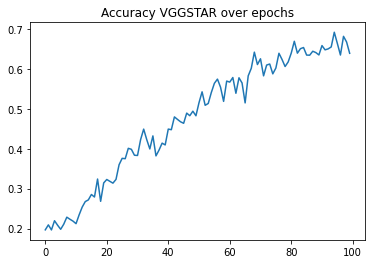

In [ ]:
DO = 'TRAIN'
if (DO=='TRAIN'):
  train(nets, loaders, optimizer, criterion, epochs=100, dev=dev,save_param=True)
else:
  state_dicts = torch.load('model.pth')
  model1.load_state_dict(state_dicts['vgg_a']) #questi state_dict vengono dalla funzione di training
  model2.load_state_dict(state_dicts['vgg_b'])
  model3.load_state_dict(state_dicts['vgg_star'])
  classifier.load_state_dict(state_dicts['classifier'])

  test(model1,classifier,test_loader_all)
  test(model2, classifier, test_loader_all)
  test(model3, classifier, test_loader_all)

  summed_state_dict = OrderedDict()

  for key in state_dicts['vgg_star']:
    if key.find('conv') >=0:
      print(key)
      summed_state_dict[key] = combo_fn(state_dicts['vgg_a'][key],state_dicts['vgg_b'][key])
    else:
      summed_state_dict[key] = state_dicts['vgg_star'][key]

  model3.load_state_dict(summed_state_dict)
  test(model3, classifier, test_loader_all)